![](images/EscUpmPolit_p.gif "UPM")

# Kaggle Challenge
## Loan Approval Prediction - New York
El reto consiste en aplicar algoritmos de Machine Learning para predecir la emisión de créditos a un cliente en función de un dataset de entrada para el entrenamiento correspondiente.

El dataset está formado por los siguientes campos:

- id # Text # Identifier of the data instance
- LoanNr_ChkDgt # Text # Identifier of the loan petition
- Name # Text # Borrower name
- City # Text # Borrower city
- State # Text # Borrower state
- Bank # Text # Bank name
- BankState # Text # Bank state
- ApprovalDate # Date/Time # Date SBA commitment issued
- ApprovalFY # Text # Fiscal year of commitment
- NoEmp # Number # Number of business employees
- NewExist # Text # 1 = Existing business, 2 = New business
- CreateJob # Number # Number of jobs created
- RetainedJob # Number # Number of jobs retained
- FranchiseCode # Text # Franchise code, (00000 or 00001) = No franchise
- UrbanRural # Text # 1 = Urban, 2 = rural, 0 = undefined
- RevLineCr # Text # Revolving line of credit: Y = Yes, N = No
- LowDoc # Text # LowDoc Loan Program: Y = Yes, N = No
- DisbursementDate # Date/Time # Disbursement date
- DisbursementGross # Currency # Amount disbursed
- BalanceGross # Currency # Gross amount outstanding
- Accept # Text # Loan approval status. 0 = not approved, 1 = approved


## 1. Importar datos

Para iniciar, se establecen las librerias a utilizar y luego se importan los datos desde el csv usando pandas. Se definen tres dataframes:
- train, contiene la información para el entrenamiento
- test, contiene la información para la predicción

In [156]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Training and test spliting
from sklearn.model_selection import train_test_split, KFold

# Estimators
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

# Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [157]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test_nolabel.csv')
#data = pd.concat([train, test])
train.head()

C:\Users\leotoast\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,b353a0b461c,3354343008,"TOGETHER GARGOYLES, INC.",BROOKLYN,NY,JPMORGAN CHASE BANK NATL ASSOC,NY,21-Dec-88,1989,20,...,0,0,0,0,N,N,30-Apr-89,"$350,000.00",$0.00,1
1,cca24bbcc48,2349745003,LAWRENCE K. ALTHISER DBA LARRY,HARTWICK,NY,CITIZENS BANK NATL ASSOC,RI,23-Mar-07,2007,3,...,1,4,0,2,N,N,30-Apr-07,"$35,000.00",$0.00,1
2,e60644381ce,6007284009,TAAMEER CONSTRUCTION INC,BROOKLYN (BOROUGH OF NEW YORK),NY,JPMORGAN CHASE BANK NATL ASSOC,IL,9-Jan-03,2003,5,...,0,5,1,1,0,N,31-Jan-03,"$50,000.00",$0.00,1
3,ffca41a2760,6047703002,"CENTRAL CONTROL SYSTEMS, INC.",SYRACUSE,NY,MANUFACTURERS & TRADERS TR CO,NY,10-Nov-93,1994,25,...,0,0,1,0,N,N,31-Jan-94,"$190,000.00",$0.00,1
4,79e48255003,6590164004,METRO SALON,ROCHESTER,NY,MANUFACTURERS & TRADERS TR CO,NY,14-Aug-03,2003,6,...,0,0,1,1,0,Y,30-Sep-03,"$30,000.00",$0.00,1


De acuerdo a los datos mostrados, se intentará intuir las variables asociadas a la predicción de la aceptación de conseción del crédito teniendo en cuenta lo siguiente:
- ApprovalDate y DisbursementDate, ambas determinan la fecha en que la SBA ha aceptado la solicitud y la fecha en que ha concedido el préstamo. Se podría calcular la diferencia entre ellas.
- NoEmp, la cantidad de empleados puede determinar que tan grande o pequeña es la empresa.
- NewExist, si es una empresa que recién esta empezando su actividad podría afectar la concesión del préstamo.
- CreateJob, si se han creado fuentes de empleo puede ser un indicador del crecimiento de la empresa.
- RetainedJob, representa la cantidad de empleos a tiempo completo existentes al momento de hacer la solicitud y que se mantendrán en caso de conseguir la aprobación.
- RevLineCr, representa el hecho de que tan pronto como se pague la deuda, la empresa puede volver a pedir prestado hasta su límite de crédito sin pasar por otro proceso de aprobación de préstamo.
- LowDoc, de ser verdadero significa que el SBA promete un procesamiento rápido (para montos inferiores a $150,000).
- DisbursementGross, la cantidad que se esta solicitando es importante en conjunto con el resto de parámetros para poder determinar la aprobación del préstamo.
- Accept, el campo más importante porque indica si se ha cedido o no el préstamo.

En la siguiente sección, se revisa cada columna para determinar su utilidad o no para la predicción.

##  2. Limpieza de datos

Se debe eliminar campos irrelevantes o no necesarios. Para esto se analizan los datos numéricos, revisando si hay datos faltantes o nulos, para así completarlos, y/o eliminar columnas no necesarias. Luego se efectúa el mismo procedimiento con los no numéricos.

In [158]:
train.info()

# Revisando duplicados
print("*****************************************************")
print(train.duplicated().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40385 entries, 0 to 40384
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40385 non-null  object 
 1   LoanNr_ChkDgt      40385 non-null  int64  
 2   Name               40382 non-null  object 
 3   City               40385 non-null  object 
 4   State              40385 non-null  object 
 5   Bank               40340 non-null  object 
 6   BankState          40338 non-null  object 
 7   ApprovalDate       40385 non-null  object 
 8   ApprovalFY         40385 non-null  object 
 9   NoEmp              40385 non-null  int64  
 10  NewExist           40378 non-null  float64
 11  CreateJob          40385 non-null  int64  
 12  RetainedJob        40385 non-null  int64  
 13  FranchiseCode      40385 non-null  int64  
 14  UrbanRural         40385 non-null  int64  
 15  RevLineCr          40250 non-null  object 
 16  LowDoc             403

Se observa que la mayoría de columnas son no numéricas y no se tienen duplicados, por lo que no se elimina ninguna fila. Por otro lado, existen 40385 filas pero en ciertas columnas hay datos con información nula.

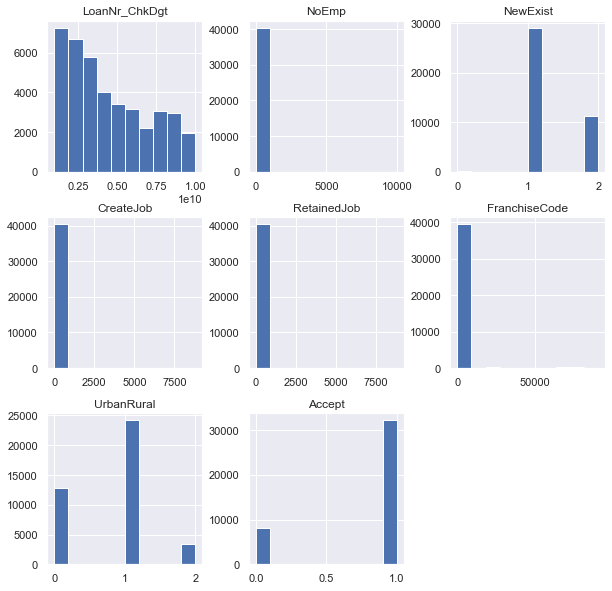

In [159]:
# Ver la distribución de cada columna
train.hist(figsize=(10,10))
plt.show()

A primera vista, parece ser que se tienen sesgos en algunas de las columnas, como NoEmp, RetainedJob, CreateJob, entre otros. Se analizará más adelante este comportamiento.

### 2.1. Revisión de datos cuantitativos

In [160]:
# Ver las estadísticas de las columnas numéricas
train.describe()

,LoanNr_ChkDgt,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Accept
count,4.038500e+04,40385.000000,40378.000000,40385.000000,40385.000000,40385.000000,40385.00000,40385.000000
mean,4.459565e+09,9.485750,1.279013,4.273666,7.128191,1218.894342,0.76885,0.796360
std,2.539048e+09,54.872591,0.451107,151.989529,152.156119,8647.991363,0.59020,0.402709
min,1.000655e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.276314e+09,2.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,3.804294e+09,4.000000,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000
75%,6.409913e+09,9.000000,2.000000,1.000000,5.000000,1.000000,1.00000,1.000000
max,9.995413e+09,9999.000000,2.000000,8800.000000,8800.000000,91110.000000,2.00000,1.000000


In [161]:
# Ver aquellos atributos numéricos con valores nulos
train.select_dtypes(include=['float64', 'int64']).isnull().sum()

LoanNr_ChkDgt    0
NoEmp            0
NewExist         7
CreateJob        0
RetainedJob      0
FranchiseCode    0
UrbanRural       0
Accept           0
dtype: int64

Se tiene que la única columna con valores nulos es **NoEmp** y se confirman los sesgos en **NoEmp, CreateJob, RetainedJob y FranchiseCode** ya que el 75% de sus datos se acumulan en valores muy por debajo de sus valores máximos.

### Columna LoanNr_ChkDgt

Se revisa el atributo y se determina que al ser un identificador, no aporta a la predicción. Además, se verifica obteniendo la cantidad de valores únicos, siendo este el total de filas del dataframe. Por lo tanto, se elimina esta columna.

In [162]:
print("Valores únicos del atributo LoanNr_ChkDgt:", len(train.LoanNr_ChkDgt.unique()))
train.drop(['LoanNr_ChkDgt'], axis=1, inplace=True)

Valores únicos del atributo LoanNr_ChkDgt: 40385


### Columna NoEmp

Se nota que este atributo se encuentra sesgado ya que la mayor parte de sus valores se acumulan en nueve empleados, lo que se corrobora con sus estadísticas, donde el 75% de sus filas acumulan esta cantidad de empleados. Por lo tanto, se reemplazan los outliers por un valor de diez que representa que todos aquellos datos tienen más de nueve empleados.

*****************************************************
La cantidad de valores mayores a nueve empleados es: 9542
La mediana es: 4.0
*****************************************************


count    40385.000000
mean         9.485750
std         54.872591
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       9999.000000
Name: NoEmp, dtype: float64

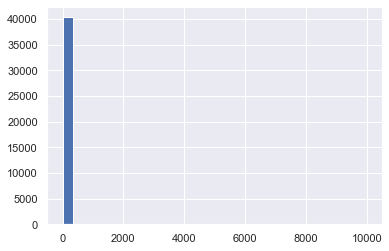

In [163]:
train['NoEmp'].hist(bins=30, range=(0, train['NoEmp'].max()))
print("*****************************************************")
print("La cantidad de valores mayores a nueve empleados es:", train.NoEmp.loc[train.NoEmp > 9].count())
print("La mediana es:", train.NoEmp.median())
print("*****************************************************")
train.NoEmp.describe()

*****************************************************
Después del cambio, la media es: 4.905583756345178
*****************************************************


<AxesSubplot:>

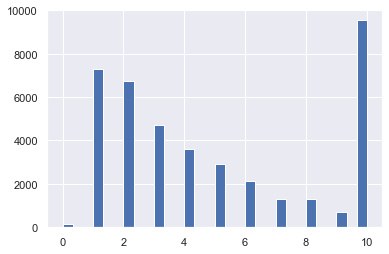

In [164]:
train.loc[train['NoEmp'] > 9, 'NoEmp'] = 10
print("*****************************************************")
print("Después del cambio, la media es:", train.NoEmp.mean())
print("*****************************************************")
train['NoEmp'].hist(bins=30, range=(0, train['NoEmp'].max()))

In [165]:
#df_train.boxplot(column='NoEmp', by = 'NewExist', return_type='axes', sym='k.') 
#train.boxplot(column='NoEmp')

In [166]:
#sns.barplot(x='NoEmp', y='Accept', data=df_train)

### Columna NewExist

Tal como se observó en el train.describe(), este atributo posee valores nulos, se decide reemplazarlos con la mediana ya que es una buena práctica.

In [167]:
train['NewExist'].fillna(train.NewExist.median(), inplace=True)

NewExist
0.0       47
1.0    29025
2.0    11313
dtype: int64

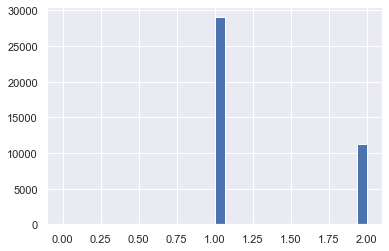

In [168]:
train['NewExist'].hist(bins=30, range=(0, train['NewExist'].max()))
train.groupby('NewExist').size()

Al ver los resultados anteriores, se tienen datos erróneos, ya que para el atributo en cuestión se estableció que unicamente puede tomar los valores 1 y 2; entonces, se reemplazan los valores donde existe el 0 por lel que más se repite, en este caso por 1.

<AxesSubplot:>

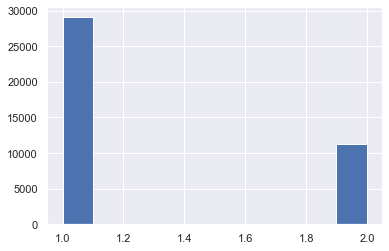

In [169]:
train.loc[train['NewExist'] == 0, 'NewExist'] = train.NewExist.mode()[0]
train['NewExist'].hist()

In [170]:
#sns.barplot(x='NewExist', y='Accept', data=train)

### Columna CreateJob

A pesar de que se tienen mayormente valores en cero, y hay una alta varianza, se deja intacto hasta revisar el análisis con el resto de columnas.

*****************************************************
La cantidad de valores con ceros es: 28279
La cantidad de valores con unos es: 3656
La cantidad de valores diferentes de cero y uno es: 8450
*****************************************************


count    40385.000000
mean         4.273666
std        151.989529
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       8800.000000
Name: CreateJob, dtype: float64

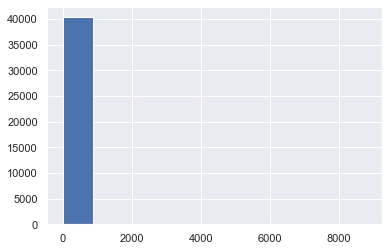

In [171]:
train['CreateJob'].hist()
print("*****************************************************")
print("La cantidad de valores con ceros es:", train.CreateJob.loc[train.CreateJob == 0].count())
print("La cantidad de valores con unos es:", train.CreateJob.loc[train.CreateJob == 1].count())
print("La cantidad de valores diferentes de cero y uno es:", train.CreateJob.loc[train.CreateJob > 1].count())
print("*****************************************************")
train['CreateJob'].describe()

In [172]:
# Ver los valores más altos
train.sort_values('CreateJob', ascending=False).CreateJob.head(25)

3390     8800
2863     8800
25406    8800
31013    8800
8190     8800
12042    8800
12052    8800
34453    8800
20921    8800
24703    8800
35966    8800
2884     8800
40189    1027
22676    1011
38644     456
8227      452
38934     450
21131     264
30679     250
10668     250
21575     206
21602     200
33949     200
8266      200
4191      168
Name: CreateJob, dtype: int64

### Columna RetainedJob

Ocurre algo parecido al caso anterior, hay una alta varianza y el 75% de sus valores es menor o igual a 5 (un valor muy pequeño comparado con el resto), sin embargo, se deja intacto hasta revisar el análisis con el resto de columnas.

*****************************************************
La cantidad de valores con ceros es: 15833
La cantidad de valores con unos es: 4482
La cantidad de valores diferentes de cero y uno es: 20070
*****************************************************


count    40385.000000
mean         7.128191
std        152.156119
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max       8800.000000
Name: RetainedJob, dtype: float64

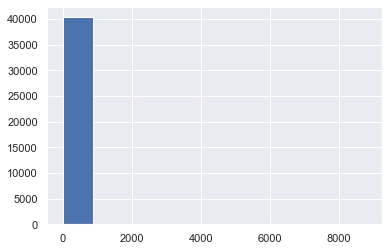

In [173]:
train['RetainedJob'].hist()
print("*****************************************************")
print("La cantidad de valores con ceros es:", train.RetainedJob.loc[train.RetainedJob == 0].count())
print("La cantidad de valores con unos es:", train.RetainedJob.loc[train.RetainedJob == 1].count())
print("La cantidad de valores diferentes de cero y uno es:", train.RetainedJob.loc[train.RetainedJob > 1].count())
print("*****************************************************")
train['RetainedJob'].describe()

In [174]:
# Ver los valores más altos
train.sort_values('RetainedJob', ascending=False).RetainedJob.head(25)

20921    8800
2863     8800
31013    8800
12042    8800
8190     8800
2884     8800
35966    8800
25406    8800
24703    8800
34453    8800
3390     8800
12052    8800
31154     815
10668     550
8266      500
18400     472
38644     450
16333     350
15390     350
25353     315
34790     300
25636     295
36174     275
39786     263
21222     251
Name: RetainedJob, dtype: int64

In [ ]:
df_train.boxplot(column='CreateJob', by = 'NewExist', return_type='axes', sym='k.')

In [ ]:
sns.FacetGrid(df_train, hue="Accept", height=5).map(sns.kdeplot, "CreateJob").add_legend()

In [ ]:
df_train['RetainedJob'].hist(bins=30, range=(0, df_train['RetainedJob'].max()))

In [ ]:
sns.FacetGrid(df_train, hue="Accept", height=5).map(sns.kdeplot, "RetainedJob").add_legend()

In [ ]:
df_train.boxplot(column='CreateJob', by = 'RetainedJob', return_type='axes', sym='k.')

### Columna FranchiseCode

Tal como muestra el resultado de train.describe(), esta columna no tiene valores nulos ni duplicados. Además, tiene un sesgo muy marcado al tener la mayor parte de sus valores entre 0 y 1 como se observa en la gráfica y en sus estadísticas.

*****************************************************
La cantidad de valores con ceros es: 12084
La cantidad de valores con unos es: 27310
La cantidad de valores diferentes de cero y uno es: 991
*****************************************************


count    40385.000000
mean      1218.894342
std       8647.991363
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max      91110.000000
Name: FranchiseCode, dtype: float64

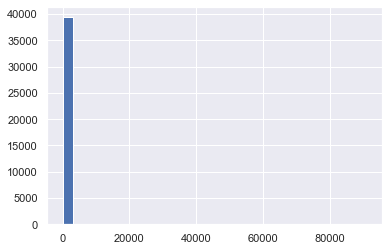

In [175]:
train['FranchiseCode'].hist(bins=30, range=(0, train['FranchiseCode'].max()))
print("*****************************************************")
print("La cantidad de valores con ceros es:", train.FranchiseCode.loc[train.FranchiseCode == 0].count())
print("La cantidad de valores con unos es:", train.FranchiseCode.loc[train.FranchiseCode == 1].count())
print("La cantidad de valores diferentes de cero y uno es:", train.FranchiseCode.loc[train.FranchiseCode > 1].count())
print("*****************************************************")
train.FranchiseCode.describe()

Entonces, se procede a cambiar los valores para eliminar el sesgo dado que esta columna es un codigo asociado al préstamo.

<AxesSubplot:>

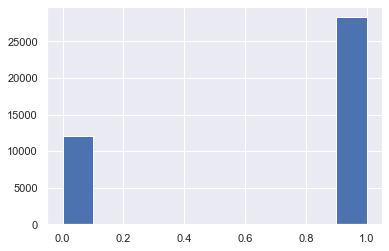

In [176]:
train.loc[train.FranchiseCode > 1, 'FranchiseCode'] = train.FranchiseCode.median()
train['FranchiseCode'].hist()
#Parece ser que FranchiseCode está relacionado con Accept
#sns.barplot(x='FranchiseCode', y='Accept', data=df_train)

### Columna UrbanRural

En este caso, se observa claramente en el histograma que se tienen tres categorías, y al no tener valores nulos ni duplicados se deja intacta.

<AxesSubplot:>

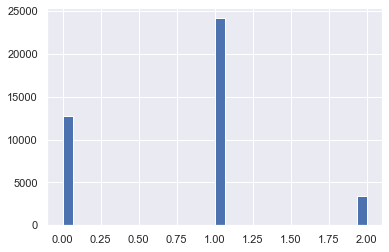

In [177]:
train['UrbanRural'].hist(bins=30, range=(0, train['UrbanRural'].max()))

In [ ]:
sns.barplot(x='UrbanRural', y='Accept', data=df_train)

### 2.2. Revisión de datos cualitativos

In [178]:
train.select_dtypes(include=['object']).describe()

,id,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross
count,40385,40382,40385,40385,40340,40338,40385,40385,40250,40330,40254,40385,40385
unique,40385,37615,2552,1,311,37,6189,87,4,7,2387,11206,1
top,b353a0b461c,SUBWAY,NEW YORK,NY,JPMORGAN CHASE BANK NATL ASSOC,NY,8-Nov-04,2005,N,N,31-Oct-05,"$50,000.00",$0.00
freq,1,69,5440,40385,6244,19924,44,3528,17540,36575,512,2907,40385


In [179]:
# Visualizar los valores nulos de los atributos que quedan
train.select_dtypes(include=['object']).isnull().sum()

id                     0
Name                   3
City                   0
State                  0
Bank                  45
BankState             47
ApprovalDate           0
ApprovalFY             0
RevLineCr            135
LowDoc                55
DisbursementDate     131
DisbursementGross      0
BalanceGross           0
dtype: int64

Al revisar los datos no numéricos, se considera que las siguientes columnas no son relevantes al momento de determinar el riesgo ya que aportan solamente información complementaria de la solicitud:
- Name, representa el nombre del usuario. Se tienen 37615 valores únicos con alta complejidad de categorizar.
- City, representa el nombre de la ciudad y al igual que Name, sus 2552 valores únicos no tendrían un alto impacto al categorizarlos.
- State, se tiene un único valor (NY) que tampoco aportaría mayor información a la predicción.
- Bank, en este caso se tienen menos variabilidad pero al ser un nombre propio no aporta información relevante.
- BankState, el mismo caso que State.
- BalanceGross, al igual que State, se tiene un único valor ($0.00) que no aportaría relevancia en la predicción.

Finalmente, se tiene valores nulos en algunas columnas, por lo que se rellenarán más adelante.

In [180]:
train.drop(['Name', 'City', 'State', 'Bank', 'BankState', 'BalanceGross'], axis=1, inplace=True)

### Columna RevLineCr

<AxesSubplot:xlabel='RevLineCr', ylabel='count'>

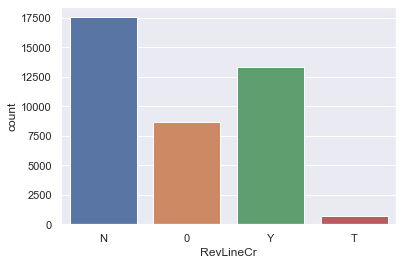

In [181]:
sns.countplot(x='RevLineCr', data=train)

Se observa que para RevLineCr solo se pueden dar dos posibles valores (Y o N) pero se tienen otros (0 y T). Asumiremos, que aquellos que tienen 0 es un N y aquellos con T es un Y. Una vez hecho esto, se rellenan los nulos con el que más se repita, es decir N de acuerdo a lo mostrado por el describe().

<AxesSubplot:xlabel='RevLineCr', ylabel='count'>

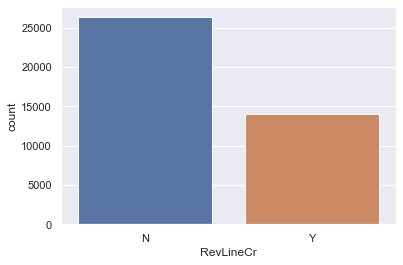

In [182]:
train.loc[train["RevLineCr"] == "0", "RevLineCr"] = 'N'
train.loc[train["RevLineCr"] == "T", "RevLineCr"] = 'Y'
train['RevLineCr'].fillna('N', inplace=True)
sns.countplot(x='RevLineCr', data=train)
#sns.barplot(x='RevLineCr', y='Accept', data=df_train)

### Columna LowDoc

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

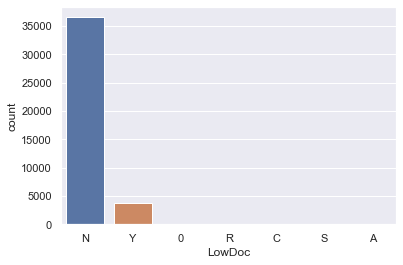

In [183]:
sns.countplot(x='LowDoc', data=train)

Un caso similar ocurre con LowDoc, sin embargo, no podemos asumir cual es Y y N. Por lo tanto, simplemente reemplazamos todos aquellos que no correspondan por el que más se repite.

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

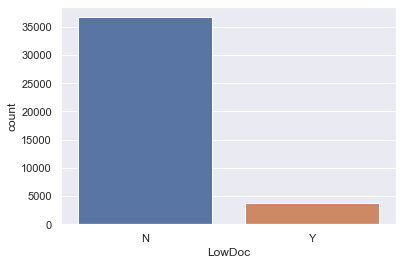

In [184]:
train['LowDoc'].fillna('N', inplace=True)
train.loc[train["LowDoc"] == "0", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "A", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "C", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "R", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "S", "LowDoc"] = 'N'
sns.countplot(x='LowDoc', data=train)

In [ ]:
sns.barplot(x='LowDoc', y='Accept', data=df_train)

### Columna DisbursementGross

Este atributo representa el monto del préstamo por lo que lo convertimos a numérico para su análisis.

In [185]:
train["DisbursementGross"] = train["DisbursementGross"].apply(lambda x: x[1:])
train["DisbursementGross"] = train["DisbursementGross"].apply(lambda s: s.strip())
train["DisbursementGross"] = train["DisbursementGross"].replace({',':''}, regex=True)
train.loc[train["DisbursementGross"] == "", "DisbursementGross"] = 0
train["DisbursementGross"] = train["DisbursementGross"].astype(float)
train.DisbursementGross.describe()

count    4.038500e+04
mean     1.469873e+05
std      2.181362e+05
min      0.000000e+00
25%      3.500000e+04
50%      7.500000e+04
75%      1.550000e+05
max      5.000000e+06
Name: DisbursementGross, dtype: float64

<AxesSubplot:>

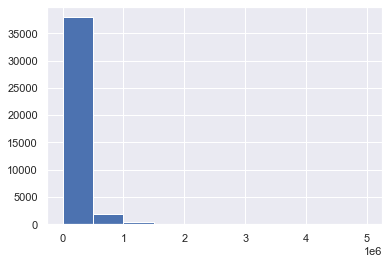

In [186]:
train.DisbursementGross.hist()

Se ve que para el 75%, los valores son menores o iguales a 155000.00. Sin embargo, no se modifica hasta observar su relación con el resto de atributos.

### Columna ApprovalFY

Estos valores representan años, entonces se lo convierte en numérico para su análisis, pero al intentarlo, salta un error debido a que se tienen valores con caracteres. Se corrigen estos valores.

In [205]:
# Se realiza una copia por si saltan errores
train_cp = train.copy()
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].astype(np.int64)

ValueError: invalid literal for int() with base 10: '1976A'

In [222]:
train_cp = train.copy()
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].astype(str)
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].apply(lambda x: x[:4])
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].astype(np.int64)
train = train_cp
train.ApprovalFY.describe()

count    40385.000000
mean      2001.670125
std          5.782541
min       1965.000000
25%       1997.000000
50%       2003.000000
75%       2006.000000
max       2014.000000
Name: ApprovalFY, dtype: float64

<AxesSubplot:>

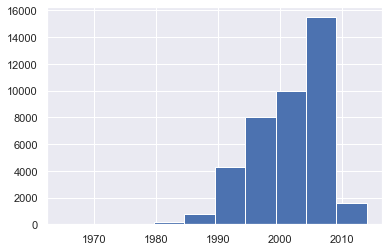

In [223]:
train.ApprovalFY.hist()

<AxesSubplot:>

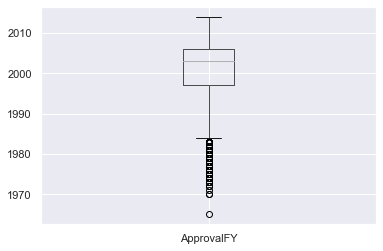

In [224]:
train.boxplot(column='ApprovalFY')

In [225]:
train.loc[train_cp.ApprovalFY <= 1985].ApprovalFY.count()

300

Una vez aplicado el cambio, aunque se tiene una distribución asimétrica, no se hace ninguna alteración ya que se considera que esta no afectaría a la predicción al tenerse una alta cantidad (300 valores) de outliers.

### Columnas ApprovalDate y DisbursementDate

Estos atributos representan las fechas de aprobación y conseción del préstamo, respectivamente. Se transforman al tipo de dato fecha para su análisis.

In [ ]:
#sns.boxplot(data=df_train.iloc[:40385,-2:-1])

In [ ]:
#df_train.boxplot(column='DisbursementGross', by = 'NewExist', return_type='axes', sym='k.')

In [ ]:
#sns.barplot(x='RevLineCr', y='DisbursementGross', hue='Accept', data=df_train)

In [ ]:
#sns.barplot(x='NewExist', y='DisbursementGross', hue='Accept', data=df_train)

In [ ]:
#sns.barplot(x="UrbanRural", y='DisbursementGross', hue='NewExist', data=df_train)

In [151]:
#df = df_train.copy()
#df.drop(['RetainedJob', 'CreateJob'], axis=1, inplace=True)
#df.info()

Previo al análisis bivariable, se categoriza cada columna no numérica como se muestra a continuación.

In [14]:
#df["NewExist"] = df["NewExist"].astype(str)
#df["FranchiseCode"] = df["FranchiseCode"].astype(str)
#df["UrbanRural"] = df["UrbanRural"].astype(str)
#df = pd.get_dummies(df, columns=['NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc'])

train.loc[train["RevLineCr"] == "N", "RevLineCr"] = 0
train.loc[train["RevLineCr"] == "Y", "RevLineCr"] = 1
train.loc[train["LowDoc"] == "N", "LowDoc"] = 0
train.loc[train["LowDoc"] == "Y", "LowDoc"] = 1
train["RevLineCr"] = train["RevLineCr"].astype(np.int64)
train["LowDoc"] = train["LowDoc"].astype(np.int64)
train["DisbursementGross"] = train["DisbursementGross"].astype(np.int64)
train.head()

,id,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,Accept
0,b353a0b461c,20,1.0,0,0,0,0,0,0,350000.0,1.0
1,cca24bbcc48,3,1.0,1,4,0,2,0,0,35000.0,1.0
2,e60644381ce,5,1.0,0,5,0,1,0,0,50000.0,1.0
3,ffca41a2760,25,1.0,0,0,0,0,0,0,190000.0,1.0
4,79e48255003,6,1.0,0,0,0,1,0,1,30000.0,1.0


In [ ]:
df

In [ ]:
df.isnull().any()

In [15]:
df.iloc[:40385,:].describe()

,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,Accept
count,40385.000000,40385.000000,40385.000000,40385.000000,40385.000000,40385.00000,40385.000000,40385.000000,4.038500e+04,40385.000000
mean,9.485750,1.280129,4.273666,7.128191,0.024539,0.76885,0.347629,0.091717,1.469873e+05,0.796360
std,54.872591,0.449068,151.989529,152.156119,0.154717,0.59020,0.476223,0.288630,2.181362e+05,0.402709
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3.500000e+04,1.000000
50%,4.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000,7.500000e+04,1.000000
75%,9.000000,2.000000,1.000000,5.000000,0.000000,1.00000,1.000000,0.000000,1.550000e+05,1.000000
max,9999.000000,2.000000,8800.000000,8800.000000,1.000000,2.00000,1.000000,1.000000,5.000000e+06,1.000000


<AxesSubplot:>

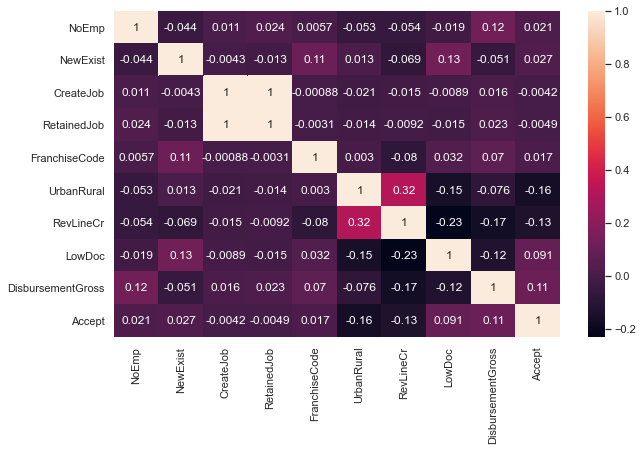

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(df.iloc[:40385,:].corr(), annot=True)

# 3. Algoritmo ML
El algoritmo secreto es Bernoulli Naive Bayes

## 3.1. Train and test splitting

In [42]:
train_data = df.iloc[:40385,:]
test_data = df.iloc[40385:,:]

Accept
0.0     8224
1.0    12161
dtype: int64


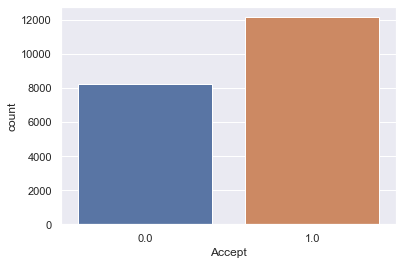

In [44]:
sns.countplot(x='Accept', data=train_data)
print(train_data.groupby('Accept').size())

In [43]:
train_data = train_data.drop(train_data.sort_values('Accept', ascending=True).tail(20000).index)
train_data.describe()

,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,Accept
count,20385.000000,20385.000000,20385.000000,20385.000000,20385.000000,20385.000000,20385.000000,20385.000000,2.038500e+04,20385.000000
mean,9.041011,1.271376,4.587147,7.567770,0.022615,0.808339,0.377532,0.077655,1.355435e+05,0.596566
std,74.061986,0.444681,163.509066,163.451392,0.148675,0.561389,0.484782,0.267635,1.986437e+05,0.490598
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000e+04,0.000000
50%,4.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,7.326100e+04,1.000000
75%,8.000000,2.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.500000e+05,1.000000
max,9999.000000,2.000000,8800.000000,8800.000000,1.000000,2.000000,1.000000,1.000000,5.000000e+06,1.000000


In [33]:
x_train_1.values
train_data.drop(['Accept', 'id'], axis=1)

,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross
0,20,1.0,0,0,0,0,0,0,350000.0
1,3,1.0,1,4,0,2,0,0,35000.0
2,5,1.0,0,5,0,1,0,0,50000.0
3,25,1.0,0,0,0,0,0,0,190000.0
4,6,1.0,0,0,0,1,0,1,30000.0
...,...,...,...,...,...,...,...,...,...
40380,25,2.0,0,0,0,0,0,1,50000.0
40381,100,1.0,10,100,0,1,0,0,1666600.0
40382,1,2.0,0,1,0,1,0,0,25000.0
40383,1,2.0,0,1,0,1,1,0,73363.0


In [45]:
from sklearn.preprocessing import StandardScaler

x_train_1 = train_data.drop(['Accept', 'id'], axis=1)
x_train = x_train_1.values
y_train = train_data['Accept'].values

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.25)

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## 3.2. Definir modelos

In [46]:
models = {"Linear SVC": LinearSVC(random_state=42, max_iter=8000), \
          "Nearest Neighbors": KNeighborsClassifier(), \
          #"Perceptron": MLPClassifier(hidden_layer_sizes=(150,), activation='tanh', solver='lbfgs', alpha=0.03, max_iter=2000), \
          #"Random Forest": RandomForestClassifier(n_estimators=100), \
          "Bernoulli": BernoulliNB()#, \
          #"SVC": SVC(kernel='poly', degree=2, gamma="auto")
         }

## 3.3. Entrenar y evaluar

In [47]:
i = 0
f1_global = []
for name in models:
    print("Start training models of {}".format(name))
    clf = models[name]
    clf.fit(X_train, Y_train)
    predicted = clf.predict(X_test)
    f1_global.append(f1_score(Y_test, predicted))
    print(confusion_matrix(Y_test, predicted))
    print(classification_report(Y_test, predicted))
    print("F1_score of %s is %s"%(name, f1_global[i]))
    print("Accuracy of %s is %s"%(name, accuracy_score(Y_test, predicted)))
    i+=1
    print("*************************************************************")
print("Global: f1={:.4f}\n".format(np.average(f1_global)))

Start training models of Linear SVC


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[2051    4]
 [3034    8]]
              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57      2055
         1.0       0.67      0.00      0.01      3042

    accuracy                           0.40      5097
   macro avg       0.54      0.50      0.29      5097
weighted avg       0.56      0.40      0.23      5097

F1_score of Linear SVC is 0.005239030779305829
Accuracy of Linear SVC is 0.4039631155581715
*************************************************************
Start training models of Nearest Neighbors
[[ 930 1125]
 [ 839 2203]]
              precision    recall  f1-score   support

         0.0       0.53      0.45      0.49      2055
         1.0       0.66      0.72      0.69      3042

    accuracy                           0.61      5097
   macro avg       0.59      0.59      0.59      5097
weighted avg       0.61      0.61      0.61      5097

F1_score of Nearest Neighbors is 0.691679748822606
Accuracy of Nearest Neighbors is 0.614675299

In [48]:
#Con datos normalizados
i = 0
f1_global = []
for name in models:
    print("Start training models of {}".format(name))
    clf = models[name]
    clf.fit(X_train_scale, Y_train)
    predicted = clf.predict(X_test_scale)
    f1_global.append(f1_score(Y_test, predicted))
    print(confusion_matrix(Y_test, predicted))
    print(classification_report(Y_test, predicted))
    print("F1_score of %s is %s"%(name, f1_global[i]))
    print("Accuracy of %s is %s"%(name, accuracy_score(Y_test, predicted)))
    i+=1
    print("*************************************************************")
    #plt.figure(figsize=(10,7))
    #plot_decision_surface(X, y, models[name])
print("Global: f1={:.4f}\n".format(np.average(f1_global)))

Start training models of Linear SVC


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[ 761 1294]
 [ 747 2295]]
              precision    recall  f1-score   support

         0.0       0.50      0.37      0.43      2055
         1.0       0.64      0.75      0.69      3042

    accuracy                           0.60      5097
   macro avg       0.57      0.56      0.56      5097
weighted avg       0.59      0.60      0.59      5097

F1_score of Linear SVC is 0.6922032875885991
Accuracy of Linear SVC is 0.5995683735530705
*************************************************************
Start training models of Nearest Neighbors
[[1041 1014]
 [ 818 2224]]
              precision    recall  f1-score   support

         0.0       0.56      0.51      0.53      2055
         1.0       0.69      0.73      0.71      3042

    accuracy                           0.64      5097
   macro avg       0.62      0.62      0.62      5097
weighted avg       0.64      0.64      0.64      5097

F1_score of Nearest Neighbors is 0.70828025477707
Accuracy of Nearest Neighbors is 0.640572886011

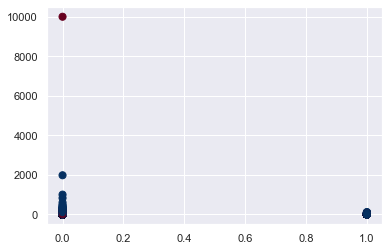

In [54]:
plt.scatter(X_train[:, 4], X_train[:, 0], c=Y_train, s=50, cmap='RdBu')
l = plt.axis()
plt.scatter(X_test[:, 4], X_test[:, 0], c=predicted, s=30, cmap='RdBu', alpha=1)
plt.axis(l);

## Mejorar modelo
Encontrar los mejores hiperparámetros.

In [60]:
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

optBNB = BayesSearchCV(
    BernoulliNB(),
    {
        'alpha': (1e-6, 1e+6, 'log-uniform'),
        'binarize': (1e-6, 1e+1, 'log-uniform'),
        'fit_prior': [True, False]
    },
    n_iter=35,
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
)

ModuleNotFoundError: No module named 'skopt'

In [ ]:
optBNB.fit(X_train, Y_train)
print("********************************************")
print("Results for Bernoulli")
print("val. score: %s" % optBNB.best_score_)
print("test score: %s" % optBNB.score(X_test, Y_test))
print("best params: %s" % str(optBNB.best_params_))

In [ ]:
#Probar modelo
best_clf = BernoulliNB(alpha=1000000, binarize=1e-06, fit_prior=False)
best_clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(Y_test, predicted))
print(classification_report(Y_test, predicted))
print("F1_score of is %s"%(f1_score(Y_test, predicted)))
print("Accuracy of is %s"%(accuracy_score(Y_test, predicted)))

In [ ]:
#Encontrar el mejor modelo usando los datos normalizados
optBNB.fit(X_train_scale, Y_train)
print("********************************************")
print("Results for Bernoulli")
print("val. score: %s" % optBNB.best_score_)
print("test score: %s" % optBNB.score(X_test_scale, Y_test))
print("best params: %s" % str(optBNB.best_params_))

In [ ]:
#Probar modelo
best_clf = BernoulliNB(alpha=1000000, binarize=1e-06, fit_prior=True)
best_clf.fit(X_train_scale, Y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(Y_test, predicted))
print(classification_report(Y_test, predicted))
print("F1_score of is %s"%(f1_score(Y_test, predicted)))
print("Accuracy of is %s"%(accuracy_score(Y_test, predicted)))

## 3.4. Predecir  datos

In [ ]:
#clf = BernoulliNB(alpha=0.012531777548068519, binarize=0.09769641421711688, fit_prior=True)
#clf = make_pipeline(BernoulliNB(alpha=0.012531777548068519, binarize=1.0634979669005702, fit_prior=True))
#clf.fit(x_train, y_train)

In [ ]:
#ids = test_data['id'].values
#x_test_1 = test_data.drop(['Accept', 'id'], axis=1)
#x_test = x_test_1.values
#predicted = clf.predict(x_test)

In [ ]:
#Con normalizacion
#clf = LinearSVC(tol=1e-02, C=100, max_iter=10000)
#clf = BernoulliNB(alpha=16.162353806896395, binarize=5.631651608138002, fit_prior=False)
x_train_scale = StandardScaler().fit_transform(x_train)
best_clf.fit(x_train_scale, y_train)

## 4. Entrega

In [ ]:
ids = test_data['id'].values
x_test_1 = test_data.drop(['Accept', 'id'], axis=1)
x_test = x_test_1.values
x_test_scale = StandardScaler().fit_transform(x_test)
predicted = best_clf.predict(x_test_scale)

In [ ]:
submission = pd.DataFrame(predicted.astype(int), index=ids, columns=['Accept'])
submission.index.name="id"
submission.to_csv(r'./submission.csv', index=True)